In [1]:
!pip install transformers datasets scikit-learn torch -q


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.4/491.4 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 99.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 68.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 36.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 15.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 84.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
import pandas as pd, torch
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report
from tqdm import tqdm
import numpy as np

# 📂 Daten laden & kombinieren
df1 = pd.read_csv("/content/Train_data.csv")[['text', 'label']]
df2 = pd.read_csv("/content/medical_data.csv").rename(columns={"Patient_Problem": "text", "Disease": "label"})[['text', 'label']]
df_all = pd.concat([df1, df2]).reset_index(drop=True)
le = LabelEncoder()
df_all["label"] = le.fit_transform(df_all["label"])
num_labels = len(le.classes_)

# 🔠 Tokenizer & Dataset
model_name = "dmis-lab/biobert-base-cased-v1.1"
tokenizer = AutoTokenizer.from_pretrained(model_name)

class MedicalDataset(Dataset):
    def __init__(self, texts, labels):
        enc = tokenizer(texts, padding=True, truncation=True, return_tensors="pt")
        self.encodings, self.labels = enc, torch.tensor(labels)
    def __getitem__(self, idx):
        item = {k: v[idx] for k, v in self.encodings.items()}
        item["labels"] = self.labels[idx]
        return item
    def __len__(self): return len(self.labels)

# 📊 Aufteilen in Trainings- und Testdaten
X_train, X_test, y_train, y_test = train_test_split(df_all["text"].tolist(), df_all["label"].tolist(), test_size=0.2)
train_loader = DataLoader(MedicalDataset(X_train, y_train), batch_size=16, shuffle=True)
test_loader = DataLoader(MedicalDataset(X_test, y_test), batch_size=16)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/313 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


In [3]:
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=num_labels)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)


pytorch_model.bin:   0%|          | 0.00/436M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dmis-lab/biobert-base-cased-v1.1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [4]:
# 🧠 Training mit Validation Loss Berechnung
train_losses, val_losses = [], []

model.train()
for epoch in range(10):
    print(f"\nEpoch {epoch+1}")
    total_train_loss = 0
    for batch in tqdm(train_loader):
        batch = {k: v.to(device) for k, v in batch.items()}
        loss = model(**batch).loss
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        total_train_loss += loss.item()

    avg_train_loss = total_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # Berechne den Validation Loss
    model.eval()
    total_val_loss = 0
    with torch.no_grad():
        for batch in test_loader:
            batch = {k: v.to(device) for k, v in batch.items()}
            loss = model(**batch).loss
            total_val_loss += loss.item()

    avg_val_loss = total_val_loss / len(test_loader)
    val_losses.append(avg_val_loss)
    print(f"Train Loss: {avg_train_loss:.4f} | Validation Loss: {avg_val_loss:.4f}")



Epoch 1


100%|██████████| 81/81 [17:44<00:00, 13.14s/it]


Train Loss: 4.7399 | Validation Loss: 4.3156

Epoch 2


100%|██████████| 81/81 [16:39<00:00, 12.33s/it]


Train Loss: 3.6983 | Validation Loss: 3.4363

Epoch 3


100%|██████████| 81/81 [16:24<00:00, 12.16s/it]


Train Loss: 2.7192 | Validation Loss: 2.6018

Epoch 4


100%|██████████| 81/81 [16:24<00:00, 12.15s/it]


Train Loss: 1.9801 | Validation Loss: 2.0638

Epoch 5


100%|██████████| 81/81 [16:26<00:00, 12.18s/it]


Train Loss: 1.5238 | Validation Loss: 1.7933

Epoch 6


100%|██████████| 81/81 [16:20<00:00, 12.10s/it]


Train Loss: 1.2283 | Validation Loss: 1.6306

Epoch 7


100%|██████████| 81/81 [16:54<00:00, 12.52s/it]


Train Loss: 1.0332 | Validation Loss: 1.5077

Epoch 8


100%|██████████| 81/81 [16:27<00:00, 12.19s/it]


Train Loss: 0.9001 | Validation Loss: 1.4251

Epoch 9


100%|██████████| 81/81 [16:32<00:00, 12.25s/it]


Train Loss: 0.8014 | Validation Loss: 1.3708

Epoch 10


100%|██████████| 81/81 [16:23<00:00, 12.14s/it]


Train Loss: 0.7145 | Validation Loss: 1.3078


In [5]:
# 🧪 Evaluation
import numpy as np  # Import numpy here

model.eval()
preds, labels = [], []
with torch.no_grad():
    for batch in test_loader:
        batch = {k: v.to(device) for k, v in batch.items()}
        out = model(**batch).logits
        preds.extend(torch.argmax(out, dim=1).cpu().numpy())
        labels.extend(batch["labels"].cpu().numpy())

# 🎯 Classification Report and Metrics
used_labels = np.unique(labels)  # This is where NumPy is needed
used_names = le.inverse_transform(used_labels)
print("\n✅ Classification Report:\n")
print(classification_report(labels, preds, labels=used_labels, target_names=used_names))
print("\n✅ Accuracy:", accuracy_score(labels, preds))
print("✅ Precision:", precision_score(labels, preds, average="weighted"))
print("✅ Recall:", recall_score(labels, preds, average="weighted"))
print("✅ F1 Score:", f1_score(labels, preds, average="weighted"))



✅ Classification Report:

                                          precision    recall  f1-score   support

                     Achilles Tendinitis       0.00      0.00      0.00         1
                                    Acne       1.00      1.00      1.00         7
                       Allergic Rhinitis       0.00      0.00      0.00         1
                                  Angina       0.00      0.00      0.00         1
                         Angina Pectoris       1.00      1.00      1.00         1
                            Appendicitis       0.50      1.00      0.67         1
                               Arthritis       1.00      1.00      1.00        11
                     Atrial Fibrillation       1.00      1.00      1.00         1
Attention Deficit Hyperactivity Disorder       0.00      0.00      0.00         1
                    Basal Cell Carcinoma       0.00      0.00      0.00         1
                        Bipolar Disorder       0.00      0.00      0.0

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m

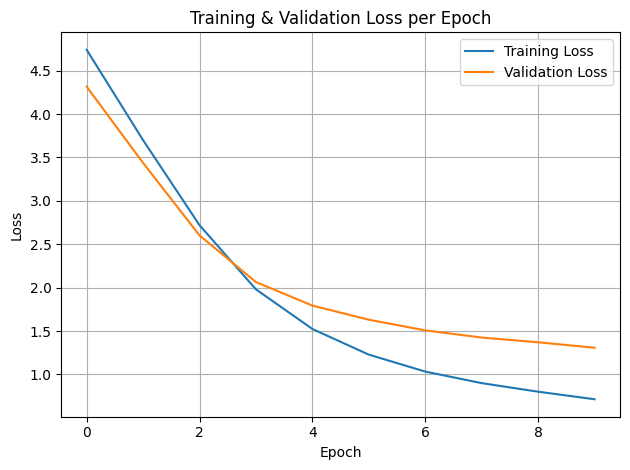

In [6]:
import matplotlib.pyplot as plt

# Plot the training and validation loss over epochs
plt.plot(train_losses, label="Training Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training & Validation Loss per Epoch")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
